In [4]:
%%capture
#@title ACE
#@markdown This code is intended for evaluating the overlap between crystallographic contacts of known fold-switching proteins
#@markdown and coevolutionary predictions made using GREMLIN and MSA Transformer.

#@markdown To run this code .pdb files are required for each conformation and an MSA file is needed in stockholm format.

#@markdown NOTE: the stockholm files were generated with HMMER 3.3.2 and renamed as 'pdbID.msa' (this program expects the .msa extension

!pip install Bio
!pip install fair-esm
!pip install kneed

import numpy as np
import pandas as pd
import os, io, itertools, filecmp, subprocess, string, torch
from itertools import cycle, islice
from scipy.spatial import distance_matrix
from google.colab import files
import matplotlib.pyplot as plt
from pathlib import Path
import esm
from Bio.PDB import PDBParser, Selection
from Bio import AlignIO, SeqIO


In [5]:
#@title Define Function to create CA based contact map
def Contact_Map_by_Residue(structure):
    #this section fills in gaps within chains
    for chain in structure[0].get_chains():
        residues = Selection.unfold_entities(chain, 'R')
        last_res = -1
        for residue in residues:
            if residue.get_id()[1] > last_res +1 and residue.get_id()[1] != residues[0].get_id()[1]:
                for idx in range(last_res+1,residue.get_id()[1]):
                    new_res = residue.copy()
                    for atom in new_res:
                        atom.detach_parent()
                        atom.set_coord([9999,9999,9999])
                    new_res.id = (' ', idx, chain.get_id())
                    chain.add(new_res)
            last_res = residue.get_id()[1]
   
    #this section makes chains have the same # of residues 
    chain_ids = [chain.id for chain in structure[0]]
    chain_res = {}
    max_length = [chain_ids[0],0]
    if len(chain_ids) >= 2:
        for chain in structure[0].get_chains():
            residues = Selection.unfold_entities(chain, 'R')
            chain_res[chain.id] = []           
            if max_length[1] < len(residues):max_length = [chain.id,len(residues)]
            for residue in residues:
                chain_res[chain.id].append(residue.resname)
        #check NTD
        for key in chain_res:
            if len(chain_res[key]) < max_length[1]:
                idx_offset = 0
                best_ntd = [idx_offset,0]
                while idx_offset < 100:
                    try:
                        n = 0
                        for idx in range(len(chain_res[key])):
                            if chain_res[key][idx] == chain_res[max_length[0]][idx+idx_offset]:n+=1
                        if n > best_ntd[1]:best_ntd=[idx_offset,n]
                        idx_offset+=1
                    except:
                        idx_offset+=1

                for chain in structure[0].get_chains():
                    if chain.id == key:
                        residues = Selection.unfold_entities(chain, 'R')
                        for idx in range(1,best_ntd[0]+1):
                            new_res = residue.copy()
                            for atom in new_res:
                                atom.detach_parent()
                                atom.set_coord([9999,9999,9999])
                            new_res.id = (' ', idx, chain.get_id())
                            chain.add(new_res)
                        residues = Selection.unfold_entities(chain, 'R')
        #check CTD
        for chain in structure[0].get_chains():
            residues = Selection.unfold_entities(chain, 'R')
            chain_res[chain.id] = []           
            if max_length[1] < len(residues):max_length = [chain.id,len(residues)]
            for residue in residues:
                chain_res[chain.id].append(residue.resname) 
        for key in chain_res:
            if len(chain_res[key]) < max_length[1]:
                diff = max_length[1] - len(chain_res[key])
                for chain in structure[0].get_chains():
                    if chain.id == key:
                        residues = Selection.unfold_entities(chain, 'R')
                        for idx in range(len(chain_res[key]),len(chain_res[key])+diff):
                            new_res = residue.copy()
                            for atom in new_res:
                                atom.detach_parent()
                                atom.set_coord([9999,9999,9999])
                            new_res.id = (' ', idx, chain.get_id())
                            chain.add(new_res)
                        residues = Selection.unfold_entities(chain, 'R')

    
    chains = {}
    for chain in structure[0].get_chains():
       residues = Selection.unfold_entities(chain, 'R')
       residues = sorted(residues, key=lambda r:r.get_id()[1])
       chains[chain] = [residue['CA'] for residue in residues]

    coor_sep = np.array([[atom.coord for atom in chains[key]] for key in chains],dtype=object)
    coor_idx = [[i for i,a in enumerate(chain)] for chain in coor_sep]
    tot_idx,offset = [],0
    for idx in range(len(coor_idx)):
        if idx == 0:
            tot_idx.append([pos for pos in coor_idx[idx]])
        else:
            offset = offset + coor_idx[idx - 1][-1] +1
            tot_idx.append([pos+offset for pos in coor_idx[idx]])
    tot_idx_flat = [pos for chain in tot_idx for pos in chain]
    
    coor = np.array([pos for chain in coor_sep for pos in chain])
    dist_matrix = distance_matrix(coor[tot_idx_flat,:],coor[tot_idx_flat,:],p=2)

    #contact map
    contact_map = np.zeros((len(tot_idx_flat),len(tot_idx_flat)))
    contact_map[dist_matrix < 9] = 1
    contact_map[dist_matrix == 0] = 0
    
    res_list = [res for key in chains for res in chains[key]]
    combo = [key for key in itertools.permutations(res_list,2)]
    res_idx = [idx for idx in itertools.permutations(list(range(len(res_list))),2)]
    
    fill = []
    for key,idx in zip(combo,res_idx):
        key_a,key_b = key[0],key[1]
        if key_a.parent != None and key_b.parent != None and idx[1] > idx[0]:
            a = np.array([key_a.parent.child_dict[key].coord for key in key_a.parent.child_dict])
            b = np.array([key_b.parent.child_dict[key].coord for key in key_b.parent.child_dict])
            dist_temp = distance_matrix(a,b,p=2)
            if np.sum(dist_temp <= 8.0).astype(bool) == True:
                fill.append(idx)
    for i,j in fill:
        contact_map[i][j] = 1
   
    #last remove hits within +-3 of the diagonal
    mask = np.zeros((len(tot_idx_flat),len(tot_idx_flat)))
    mask = np.abs(np.arange(len(tot_idx_flat)) - np.arange(len(tot_idx_flat))[:,np.newaxis]) <= 3
    contact_map[mask] = 0

    tu = np.triu_indices(contact_map.shape[0])
    contact_map[tu[::-1]] = contact_map[tu]

    #as is this will only handle up to 5 chains, makes interchain squares darker
    mask = np.zeros((len(tot_idx_flat),len(tot_idx_flat)))
    perm = list(range(len(tot_idx)))
    perm = [p for p in itertools.permutations(perm, r=2) if p[0] < p[1]]

    value = 0.2
    for i in perm:
        mask_idx = np.array(list(itertools.product(tot_idx[i[0]],tot_idx[i[1]])))
    
        mask[mask_idx[:,0],mask_idx[:,1]] = 1 - int(i[1]-i[0])*value
        mask[mask_idx[:,1],mask_idx[:,0]] = 1 - int(i[1]-i[0])*value

    return contact_map,mask

def Collapse_Multimer_Contact_map(structure,contact_map):
    chain_ids = [chain.id for chain in structure[0]]
    chains = {}
    if len(chain_ids) >= 2:
        for chain in structure[0].get_chains():
            residues = Selection.unfold_entities(chain, 'R')
            chains[chain.id] = len(residues)
            
            
        new_cmap = np.zeros((chains[chain_ids[0]],chains[chain_ids[0]]))
        
        increment=0
        idx = [0]
        for id in chain_ids:
            print(chains[id])
            idx.append(increment+chains[id])
            increment+=chains[id]
        
        intra_idx = [p for p in itertools.product(idx, repeat=2) if p[0] < p[1]]
        intra_idx = [p for p in intra_idx if p[0] == p[1]-chains[chain_ids[0]]]

        # This is now a superimposition of the intramolecular contacts not one individual instance
        intra = new_cmap
        for idx in intra_idx:
            #intra = new_cmap + contact_map[0:chains[chain_ids[0]],0:chains[chain_ids[0]]]*2
            intra = intra + contact_map[idx[0]:idx[1],idx[0]:idx[1]]
        mask = np.nonzero(intra)
        intra[mask] = 2
   
        # Superimposition of all possible intermolecular contacts
        #inter = new_cmap + contact_map[chains[chain_ids[0]]:chains[chain_ids[0]]+chains[chain_ids[1]],0:chains[chain_ids[0]]]
        inter = new_cmap
        inter_idx = [p for p in itertools.product(intra_idx, repeat=2) if p[0][0]+p[0][1] > p[1][0]+p[1][1]]

        for idx in inter_idx:
            inter = inter + contact_map[idx[0][0]:idx[0][1],idx[1][0]:idx[1][1]]
        mask = np.nonzero(inter)
        inter[mask] = 1
        
        #last remove hits within +-3 of the diagonal
        mask = np.zeros(inter.shape)
        mask = np.abs(np.arange(mask.shape[0]) - np.arange(mask.shape[1])[:,np.newaxis]) <= 3
        inter[mask] = 0

        new_cmap = intra + inter
        
        return new_cmap
    
    else:
        mask = np.nonzero(contact_map)
        contact_map[mask] = 2
        return contact_map

&#8592;

&#8592;

You will need to upload the XXXX.pdb files to this session.
Click on the Files icon to the left then choose 'upload to session storage'

Once the files are uploaded type the file names below.

&#8592;

&#8592;

In [7]:
%%capture
#@title Enter the names of the PDB files

#@markdown If you are only interested in one structure enter the same file name for both:

pdb_1 = '5ond.pdb'  #@param {type:"string"}
pdb_2 = '6c6s.pdb'  #@param {type:"string"}

parser = PDBParser()
structure_1 = parser.get_structure(f'{pdb_1[0:4]}',f'{pdb_1}')
contact_map_1,mask_1 = Contact_Map_by_Residue(structure_1)
cmap_collapse_1 = Collapse_Multimer_Contact_map(structure_1,contact_map_1)

structure_2 = parser.get_structure(f'{pdb_2[0:4]}',f'{pdb_2}')
contact_map_2,mask_2 = Contact_Map_by_Residue(structure_2)
cmap_collapse_2 = Collapse_Multimer_Contact_map(structure_2,contact_map_2)


def size(row):  
    if row['type'] =='INTRA':return 100
    elif row['type'] == 'INTER':return 30
def sort(row,idx):
    if [row['j'],row['i']] in idx:
      return 'both'
    elif row['j'] - row['i'] > 0:
      return 'pdb_1'
    elif row['j'] - row['i'] < 0:
      return 'pdb_2'

def Create_DF(contact_map,combo='n'):
    inter = {'i':[],'j':[]}
    intra = {'i':[],'j':[]}
    for i in range(contact_map.shape[0]):
        for j in range(contact_map.shape[1]):
            if contact_map[i,j] == 1:
                inter['i'].append(i)
                inter['j'].append(j)
            elif contact_map[i,j] == 2:
                intra['i'].append(i)
                intra['j'].append(j)
            elif contact_map[i,j] == 3:
                inter['i'].append(i)
                inter['j'].append(j)
                intra['i'].append(i)
                intra['j'].append(j)

    df_inter = pd.DataFrame.from_dict(inter)
    df_inter['type'] = 'INTER'
    
    df_intra = pd.DataFrame.from_dict(intra)
    df_intra['type'] = 'INTRA'
    
    df = pd.concat([df_inter,df_intra])

    df['size'] = df.apply(lambda row: size(row), axis=1)
    if combo == 'y':
      colors = {'pdb_1':'#d8d8d8', 'pdb_2':'#000000','both':'#767676'}
      idx = df[['i','j']].to_numpy().tolist()
      df['pdb'] = df.apply(lambda row: sort(row,idx), axis=1)

      f, ax = plt.subplots(1,1,figsize=(9,9))
      ax.scatter(x=df['i'], y=df['j'],c=df['pdb'].map(colors), s=df['size'], linewidth=0, label=df['type'])
      plt.show()

    return df
df_pdb_1 = Create_DF(cmap_collapse_1)
df_pdb_2 = Create_DF(cmap_collapse_2)

Maximum number of overlapping 1s: 28519.0
Starting indices of the optimal alignment: (79, 79)


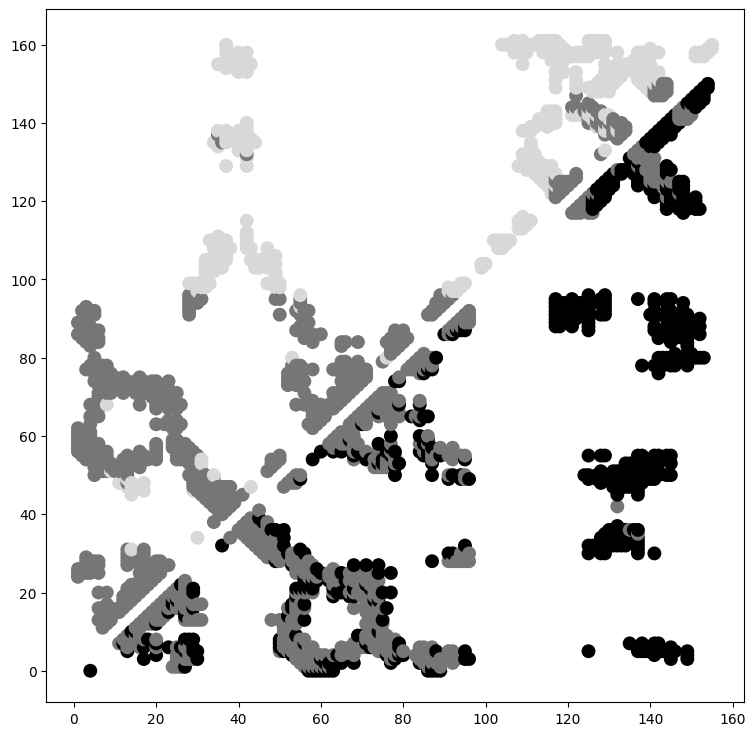

-------Fold-Switching crystalographic information-------
Number of unique contacts in PDB1:        444
Number of unique contacts in PDB2:        612
Number of unique contacts common to both: 1322





In [8]:
#@title Generate dual fold contact map
#@markdown Ensure crystallographic information contains only heavy atoms of the protein
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def Compare_Contact_Maps(contact_map1,structure1,contact_map2,structure2):
    
    #This will always try to align to the second chain
    A = contact_map1
    B = contact_map2
    chain_ids = [chain.id for chain in structure2[0]]
    structure = structure2

    n = int(B.shape[0]*0.5)
    B = np.pad(B, n, pad_with, padder=0)
    B = Mask_Lower_Triangle(B)

    # Initialize the maximum number of overlapping 1s
    max_overlap = 0
    
    # Initialize the starting indices of the optimal alignment
    start_i, start_j = 0, 0

    beg = range(B.shape[0]-A.shape[0]+1)
    end = range(B.shape[0]-A.shape[0]+1)
    for i,j in zip(beg,end):
        subset = B.copy()
        subset = subset[i:i+A.shape[0], j:j+A.shape[1]]
        mask = np.nonzero(subset)
        subset[mask] = 1
        subset = np.triu(subset,-1)

        mask = np.nonzero(A)
        temp = A.copy()
        temp[mask] = 1
        temp = np.triu(temp, -1)

        check = subset + temp
        check_overlap = np.argwhere(check > 1)

        # Get the number of overlapping 1s
        overlap = check[check_overlap].sum()
        # Update the maximum number of overlapping 1s and the starting indices if necessary
        if overlap > max_overlap:
            max_overlap = overlap
            start_i, start_j = i, j
    
    # Print the maximum number of overlapping 1s and the starting indices of the optimal alignment
    print(f"Maximum number of overlapping 1s: {max_overlap}")
    print(f"Starting indices of the optimal alignment: ({start_i}, {start_j})")
    
    subset_B = B[start_i:start_i+A.shape[0],start_j:start_j+A.shape[1]]
    A.T == np.rot90(np.fliplr(A))
    lower_triangle_idx = np.tril_indices(A.shape[0],-1)
    subset_B[lower_triangle_idx] = A[lower_triangle_idx]
    B[start_i:start_i+A.shape[0],start_j:start_j+A.shape[1]] = subset_B

    #This should reset contacts making the larger chain start at 1
    B = np.delete(B,np.s_[0:n-1],1)
    B = np.delete(B,np.s_[0:n-1],0)

    #plt.imshow(B, cmap='binary', interpolation='none')
    #plt.show()
    
    return B

def Mask_Lower_Triangle(contact_map):
    mask = np.triu(np.ones(contact_map.shape))
    return contact_map * mask

pdb_1_2_combo = Compare_Contact_Maps(cmap_collapse_1,structure_1,cmap_collapse_2,structure_2)
df_pdb_1_2 = Create_DF(pdb_1_2_combo,combo='y')
x_first =  df_pdb_1_2[df_pdb_1_2['pdb'] == 'pdb_1']
x_first =  x_first[['i','j']].to_numpy()
x_second = df_pdb_1_2[df_pdb_1_2['pdb'] == 'pdb_2']
x_second = x_second[['j','i']].to_numpy()
x_common = df_pdb_1_2[df_pdb_1_2['pdb'] == 'both']
x_common = x_common[['j','i']].to_numpy()
print('-------Fold-Switching crystalographic information-------')
print('Number of unique contacts in PDB1:        {:}'.format(int(len(x_first))))
print('Number of unique contacts in PDB2:        {:}'.format(int(len(x_second))))
print('Number of unique contacts common to both: {:}\n'.format(int(len(x_common))))
print('\n')
xcontact = df_pdb_1_2.loc[df_pdb_1_2['type'] == 'INTRA']
xcontact = xcontact.to_numpy()
xcontact = [(i[0],i[1]) for i in xcontact]

In [ ]:
#@title Upload multiple sequence alignment in stockholm format
#@markdown ColabFold's code to generate an MSA is available for convenience
#@markdown Skip this cell if ColabFold will be used to create the MSA
MSA_file = ''  #@param {type:"string"}

align = AlignIO.read(f"{MSA_file}", "stockholm")
seqs = [str(record.seq[:]) for record in align]
query_length = len(seqs[0].replace('-',''))
names = [record.id[:].ljust(36) for record in align]

if os.path.isdir(MSA_file[:-4]) == False:        
  os.system(f'mkdir {MSA_file[:-4]}')

# MSA generation 
###-----------------------------skip if uploading your own file-----------------------------

In [9]:
#@title Install software to run a limited version of ColabFold's MSA generation
#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

# setup device
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import tensorflow as tf
import jax

try:
  # check if TPU is available
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Running on TPU')
  DEVICE = "tpu"
except:
  if jax.local_devices()[0].platform == 'cpu':
    print("WARNING: no GPU detected, will be using CPU")
    DEVICE = "cpu"
  else:
    print('Running on GPU')
    DEVICE = "gpu"
    # disable GPU on tensorflow
    tf.config.set_visible_devices([], 'GPU')

from IPython.utils import io
import subprocess
import tqdm.notebook

from sys import version_info 
python_version = f"{version_info.major}.{version_info.minor}"

install_jackhmmer = True
GIT_REPO = 'https://github.com/deepmind/alphafold'
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
TMP_DIR = "tmp"
os.makedirs(TMP_DIR, exist_ok=True)

# if not already installed
total = 55
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  if not os.path.isdir("alphafold"):
    # download alphafold code
    os.system(f"git clone {GIT_REPO} alphafold; cd alphafold; git checkout 1d43aaff941c84dc56311076b58795797e49107b")
    os.system(f"git clone https://github.com/sokrypton/ColabFold.git")

    # apply patches
    os.system(f"patch -u alphafold/alphafold/model/model.py -i ColabFold/beta/model.patch")
    os.system(f"patch -u alphafold/alphafold/model/mapping.py -i ColabFold/beta/mapping.patch")
    os.system(f"patch -u alphafold/alphafold/model/modules.py -i ColabFold/beta/modules.patch")
    os.system(f"patch -u alphafold/alphafold/model/folding.py -i ColabFold/beta/folding.patch")
    os.system(f"patch -u alphafold/alphafold/model/config.py -i ColabFold/beta/config.patch")
    # apply multi-chain patch from Lim Heo @huhlim
    os.system(f"patch -u alphafold/alphafold/common/protein.py -i ColabFold/beta/protein.patch")
    pbar.update(4)

    os.system(f"pip install biopython dm-haiku==0.0.9 ml-collections py3Dmol")
    pbar.update(6)

    # download model params (speedup from kaczmarj)
    os.system(f"mkdir --parents {PARAMS_DIR}")
    os.system(f"curl -fsSL {SOURCE_URL} | tar x -C {PARAMS_DIR}")
    pbar.update(14+27)

    # install hhsuite
    os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C {TMP_DIR}/")

    # install jackhmmer
    if install_jackhmmer:
      os.system(f"sudo apt install --quiet --yes hmmer")
      pbar.update(3)

      # create a ramdisk to store a database chunk to make Jackhmmer run fast.
      os.system(f"sudo mkdir -m 777 --parents /tmp/ramdisk")
      os.system(f"sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk")
      pbar.update(1)

    else:
      pbar.update(4)

  else:
    pbar.update(55)

########################################################################################
# --- Python imports ---
if 'alphafold' not in sys.path:
  sys.path.append('alphafold')
if 'ColabFold/beta' not in sys.path:
  sys.path.append('ColabFold/beta')

if f"{TMP_DIR}/bin" not in os.environ['PATH']:
  os.environ['PATH'] += f":{TMP_DIR}/bin:{TMP_DIR}/scripts"

import colabfold as cf
import colabfold_alphafold as cf_af

import json
import matplotlib.pyplot as plt
import numpy as np

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

Running on GPU


  0%|          | 0/55 [elapsed: 00:00 remaining: ?]

/usr/local/lib/python3.10/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


In [10]:
#@title Define sequence to generate MSA
import re

# define sequence
sequence = 'MQSWYLLYCKRGQLQRAQEHLERQAVNCLAPMITLEKIVRGKRTAVSEPLFPNYLFVEFDPEVIHTTTINATRGVSHFVRFGASPAIVPSAVIHQLSVYKPKDIVDPATPYPGDKVIITEGAFEGFQAIFTEPDGEARSMLLLNLINKEIKHSVKNTEFRKA' #@param {type:"string"}
jobname = "test" 
homooligomer =  "1"

I = cf_af.prep_inputs(sequence, jobname, homooligomer, clean=IN_COLAB)

homooligomer: 1
total_length: 162
output_dir: prediction_test_7f1b1


running mmseqs2


  0%|          | 0/150 [elapsed: 00:00 remaining: ?]

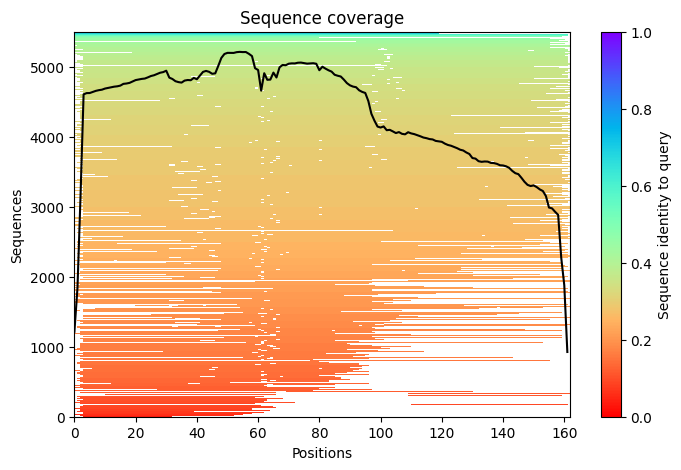

In [11]:
#@title Search against genetic databases

#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment 
#@markdown (MSA) that will be used by AlphaFold. In particular, 
#@markdown you’ll see how well each residue is covered by similar 
#@markdown sequences in the MSA.
#@markdown (Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab.)

#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","jackhmmer","single_sequence","precomputed"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
#@markdown - `jackhmmer` - default method from Deepmind (SLOW, but may find more/less sequences).


add_custom_msa = False 
msa_format = "sto"



pair_mode = "unpaired" 
pair_cov = 50 
pair_qid = 20 

# --- Search against genetic databases ---

I = cf_af.prep_msa(I, msa_method, add_custom_msa, msa_format,
                   pair_mode, pair_cov, pair_qid, TMP_DIR=TMP_DIR)
mod_I = I

msa_ = I['msas']
if len(msa_) > 0:
  msa_ = np.asarray([list(seq) for seq in msa_])

seqs = msa_[0]
query_length = len(seqs[0].replace('-',''))
names = [str(idx).ljust(36) for idx in range(len(seqs))]

MSA_file = "Colab_autoMSA"

if os.path.isdir(MSA_file[:-4]) == False:        
  os.system(f'mkdir {MSA_file[:-4]}')

if len(I["msas"][0]) > 1:
  plt = cf.plot_msas(I["msas"], I["ori_sequence"])
  plt.savefig(os.path.join(I["output_dir"],"msa_coverage.png"), bbox_inches = 'tight', dpi=200)
  plt.show()

# MSA generation 
###-----------------------------End of ColabFold MSA section -----------------------------

In [13]:
%%capture
#@title This will load HHSuite which will be used to generate sub-family alignments
my_file = Path("bin/hhfilter")
if not my_file.is_file():
  !wget https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz 
  !tar xvfz hhsuite-3.3.0-SSE2-Linux.tar.gz
  !export PATH="$(pwd)/bin:$(pwd)/scripts:$PATH"

class Edit_MSA():
    def __init__(self,file_in,msa,names,parser):
        #write MSA in a3m format for HHFILTER
        names = [">"+line for line in names]
        gen = np.array([el for el in list(self.roundrobin(names,msa))])
        np.savetxt('temp.a3m',gen, fmt='%s')

        #Run HHFILTER to generate subfamily alignments
        qid_list = []
        for i in np.linspace(0,50,num=51):
            if i < 10:i = str('0{:}'.format(int(i)))
            else: i = str(int(i))
            qid_list.append(i)
        
        for i in qid_list: 
            # os.system('hhfilter -i temp.a3m -o {:}/msa_{:}.qid -M first -qid {:}'.format(file_in[:-4],i,i))
            subprocess.check_output('bin/hhfilter -i temp.a3m -o {:}/msa_{:}.a3m -qid {:}'.format(file_in[:-4],i,i), shell=True)
            # subprocess.check_output('reformat.pl a3m sto trial.a3m {:}/{:}/{:}.sto'.format(self.cwd,self.file_in[:-4],i), shell=True)
        subprocess.check_output('rm -f temp.a3m ', shell=True)

        #remove any alignment generated by qid filter that is redundant
        files = [i for i in os.listdir('{:}/'.format(file_in[:-4])) if os.path.isfile(os.path.join('{:}/'.format(file_in[:-4]), i))]
        files = [i for i in files if i[-3:] == 'a3m']
        files = sorted(files, key = lambda x: x.rsplit('.', 1)[0])
        remove = []
        for i in range(len(files)-1):
            if filecmp.cmp('{:}/{:}'.format(file_in[:-4],files[i]), '{:}/{:}'.format(file_in[:-4],files[i+1])) == True:
                remove.append(files[i+1])
        for i in remove:
            os.system('rm -f {:}/{:}'.format(file_in[:-4],i))

        #filter thresholds
        self.row = 0.25
        self.column = 0.75

        files = [i for i in os.listdir('{:}/'.format(file_in[:-4])) if os.path.isfile(os.path.join('{:}/'.format(file_in[:-4]), i))]
        files = [i for i in files if i[-3:] == 'a3m']
        files = sorted(files, key = lambda x: x.rsplit('.', 1)[0])
        
        if parser == 'QID' or parser == 'E-value':
            pass
        else:
            print('You can only choose E-value or QID...')
            exit()

        for file in files:
            align = AlignIO.read("{:}/{:}".format(file_in[:-4],file), "fasta")
            seqs = [str(record.seq[:]) for record in align]
            names = [record.id[:].ljust(36) for record in align]
            
            df = pd.DataFrame(seqs, index=(names))
            df = df[0].str.split('',expand=True)             #seperate all a.a. into there own column
            if df[0][0] == '':
                df = df.drop([0],axis=1)                     #if first column is empty it is deleted
            temp = list(df)
            if df[temp[-1:][0]][0] == '':                    #if the last column is empty delete it
                df = df.drop(temp[-1:][0],axis=1)
            print('msa started at {:} rows and {:} columns'.format(df.shape[0],df.shape[1]))

            remove = []
            for i in df.columns:
                if df[i][0] == '-':
                    remove.append(i)
            df = df.drop(columns=remove)
            aa = list(df)
            aa = list(range(aa[0],len(aa)+int(aa[0])))
            name = list(df.index.values)
            msa = df.values.tolist()
            
            print('msa has been reduced to {:} rows and {:} columns'.format(df.shape[0],df.shape[1]))
            
            msa,name = self.Remove_rows(msa, name)
            df_a3m = pd.DataFrame(msa,index=(name),columns=aa)
            msa_a3m = df_a3m.to_numpy()
            msa_a3m = [''.join(line) for line in msa_a3m]
            names_a3m = list(df_a3m.index)
            names_a3m = [">"+line for line in names_a3m]
            gen = np.array([el for el in list(self.roundrobin(names_a3m,msa_a3m))])
            np.savetxt('{:}/{:}'.format(file_in[:-4],file),gen, fmt='%s')
            
            msa,name,aa = self.Remove_columns(msa, name, aa)
            df = pd.DataFrame(msa,index=(name),columns=aa)
            df.to_csv('{:}/{:}.csv'.format(file_in[:-4],file[:-4]))
            os.system('sed "s/,//g" < {:}/{:}.csv > {:}/{:}.out'.format(file_in[:-4],file[:-4],file_in[:-4],file[:-4]))
            os.system('sed -i -e "1d" {:}/{:}.out'.format(file_in[:-4],file[:-4]))
            os.system('rm -f {:}/{:}.out-e'.format(file_in[:-4],file[:-4]))
            

        if parser == 'E-value':
            files = [i for i in os.listdir('{:}/'.format(file_in[:-4])) if os.path.isfile(os.path.join('{:}/'.format(file_in[:-4]), i))]
            files = [i for i in files if i[-3:] == 'a3m']
            files = sorted(files, key = lambda x: x.rsplit('.', 1)[0])
            
            print('E-value is active...')
            output = [sum(1 for line in open('{:}/{:}'.format(file_in[:-4],file))) for file in files]
            align = AlignIO.read("{:}/{:}".format(file_in[:-4],files[0]), "fasta")
            seqs = [str(record.seq[:]) for record in align]
            names = [record.id[:].ljust(36) for record in align]
            df = pd.DataFrame(seqs, index=(names))
                        
            for idx in range(len(output)):
                df_iter = df.copy()
                N = int((output[0] - output[idx])/2)
                if N != 0: df_iter = df_iter.iloc[:-N]
                df_iter = df_iter[0].str.split('',expand=True)             #seperate all a.a. into there own column
                if df_iter[0][0] == '':
                    df_iter = df_iter.drop([0],axis=1)                     #if first column is empty it is deleted
                temp = list(df_iter)
                if df_iter[temp[-1:][0]][0] == '':                    #if the last column is empty delete it
                    df_iter = df_iter.drop(temp[-1:][0],axis=1)
                print('msa started at {:} rows and {:} columns'.format(df_iter.shape[0],df_iter.shape[1]))
                df_a3m = df_iter
                msa_a3m = df_a3m.to_numpy()
                msa_a3m = [''.join(line) for line in msa_a3m]
                names_a3m = list(df_a3m.index)
                names_a3m = [">"+line for line in names_a3m]
                gen = np.array([el for el in list(self.roundrobin(names_a3m,msa_a3m))])
                np.savetxt('{:}/{:}'.format(file_in[:-4],files[idx]),gen, fmt='%s')
                
                df_iter.to_csv('{:}/{:}.csv'.format(file_in[:-4],files[idx][:-4]))
                os.system('sed "s/,//g" < {:}/{:}.csv > {:}/{:}.out'.format(file_in[:-4],files[idx][:-4],file_in[:-4],files[idx][:-4]))
                os.system('sed -i -e "1d" {:}/{:}.out'.format(file_in[:-4],files[idx][:-4]))
                os.system('rm -f {:}/{:}.out-e'.format(file_in[:-4],files[idx][:-4]))
        
        #remove any alignment preprocessing made redundant
        files = [i for i in os.listdir('{:}/'.format(file_in[:-4])) if os.path.isfile(os.path.join('{:}/'.format(file_in[:-4]), i))]
        files = [i for i in files if i[-3:] == 'out']
        files = sorted(files, key = lambda x: x.rsplit('.', 1)[0])
        remove = []
        for i in range(len(files)-1):
            if filecmp.cmp('{:}/{:}'.format(file_in[:-4],files[i]), '{:}/{:}'.format(file_in[:-4],files[i+1])) == True:
                remove.append(files[i+1])
        for i in remove:
            os.system('rm -f {:}/{:}.out'.format(file_in[:-4],i[:-4]))
            os.system('rm -f {:}/{:}.a3m'.format(file_in[:-4],i[:-4]))
            os.system('rm -f {:}/{:}.csv'.format(file_in[:-4],i[:-4]))
            os.system('rm -f {:}/{:}.pkl'.format(file_in[:-4],i[:-4]))

            
    def roundrobin(self,*iterables):
        "roundrobin('ABC', 'D', 'EF') --> A D E B F C"
        # Recipe credited to George Sakkis
        num_active = len(iterables)
        nexts = cycle(iter(it).__next__ for it in iterables)
        while num_active:
            try:
                for next in nexts:
                    yield next()
            except StopIteration:
                # Remove the iterator we just exhausted from the cycle.
                num_active -= 1
                nexts = cycle(islice(nexts, num_active))

    def Remove_rows(self,msa,name):

        """
        Filter sequences that cover less than 25% of the query sequence
        """

        # Create list of sequences that have too many gaps and remove them from both msa and name
        msa_red = []
        name_red = []

        for i in range(len(msa)):
            if msa[i].count('-')/len(msa[0]) > self.row:
                msa_red.append(msa[i])
                name_red.append(name[i])
        for i in msa_red:
            msa.remove(i)
        for i in name_red:
            name.remove(i)
        #__________________________________________________________

        # check to see if filter removed too many sequences or none.
        if len(msa_red) == 0:
            print('All sequences in alignment passed the {:} row gap threshold!'.format(self.row))
        elif len(msa_red) == len(msa):
            print('This gap cutoff has removed all sequences from the msa, choose a higher cutoff.')
        else:
            print('msa has been reduced to {:} rows and {:} columns'.format(len(msa),len(msa[0])))
        return msa,name
    
    def Remove_columns(self,msa,name,aa):
        """
        columns that are made up of greater than 25% gaps will be excluded 
        """
        # create datafrom with positions as column titles and seq name as index titles
        df = pd.DataFrame(msa,index=(name))      #create initial data frame
        # aa = list(range(aa[0],len(aa)+int(aa[0])))
        df.columns = aa
        #__________________________________________________________

        #Remove columns 
        freq_all = []
        freq_ = []
        temp = list(df)
        for f in temp:
            freq_.append((df[df[f]=='-'].shape[0]/df[f].count(),f))   #isolate frequency of - in columns
            freq_all.append((df[f].value_counts(normalize=True)))  #all frequencies if needed in columns
        for f in freq_:
            if f[0] > self.column:
                df = df.drop([f[1]],axis=1)

        #__________________________________________________________

        print('msa has been reduced to {:} rows and {:} columns'.format(df.shape[0],df.shape[1]))
        name = list(df.index.values)
        msa = df.values.tolist()
        aa = list(df)

        return msa, name, aa

In [14]:
#@title Prepare MSA for input into GREMLIN algorithm and MSATransformer algorithm
Edit_MSA(MSA_file,seqs,names,'QID')

msa started at 4765 rows and 162 columns
msa has been reduced to 4765 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa started at 4763 rows and 162 columns
msa has been reduced to 4763 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa started at 4762 rows and 162 columns
msa has been reduced to 4762 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa started at 4760 rows and 162 columns
msa has been reduced to 4760 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa started at 4756 rows and 162 columns
msa has been reduced to 4756 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa has been reduced to 3006 rows and 162 columns
msa started at 4748 rows and 162 columns
msa 

In [15]:
#@title Run MSA-transformer

from typing import List, Tuple
import gc
from time import sleep
from numba import cuda
import numba


# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str, nseq: int) -> List[Tuple[str, str]]:
    """ Reads the first nseq sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq)))
            for record in itertools.islice(SeqIO.parse(filename, "fasta"), nseq)]

def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)


def Make_DataFrame(tensor_in,output,query_length):
    mrf = tensor_in
    
    temp = {'i':[],'j':[],'zscore':[]}
    for i in range(mrf.shape[0]):
        for j in range(mrf.shape[1]):
            temp['i'].append(i)
            temp['j'].append(j)
            temp['zscore'].append(mrf[i][j].item())
      
    pd_mtx = pd.DataFrame.from_dict(temp)
    
    temp = pd_mtx
    N = int(query_length)
    zero = np.zeros((N,N))
    for index, row in temp.iterrows():
        zero[int(row['i']),int(row['j'])] = row['zscore']
        zero[int(row['j']),int(row['i'])] = row['zscore']
    
    top = pd_mtx.loc[pd_mtx['j'] - pd_mtx['i'] > 3].sort_values("zscore",ascending=False)

    return top.head(int(output*mrf.shape[0])),zero

def MSA_TR(msa,files,output,query_length,Beg=0,End=0):
    #run msa transformer on all alignments
    print('Start msa transformer...')
    msa_data = []
    for i in files:
        temp = read_msa("{:}/{:}".format(msa,i),64)
        if Beg != 0:
            temp_edit = []
            for i in range(len(temp)):
                short = (temp[i][0],temp[i][1][Beg:])
                temp_edit.append(short)
            temp = temp_edit
        if End != 0:
            temp_edit = []
            for i in range(len(temp)):
                short = (temp[i][0],temp[i][1][:-End])
                temp_edit.append(short)
            temp = temp_edit
        msa_data.append(temp)

    #msa_transformer, msa_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
    #msa_batch_converter = msa_alphabet.get_batch_converter()

    print('Running MSA-transformer...')

    if torch.cuda.is_available():  
      dev = "cuda:0" 
    else:  
      dev = "cpu"
    device = torch.device(dev)

    for n,msa in enumerate(msa_data):
      gc.collect()
      torch.cuda.empty_cache()
      msa_transformer, msa_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
      msa_batch_converter = msa_alphabet.get_batch_converter()
      msa_batch_labels, msa_batch_strs, msa_batch_tokens = msa_batch_converter(msa)
      msa_transformer = msa_transformer.to(device)
      msa_batch_tokens = msa_batch_tokens.to(device)
      msa_transformer.cuda().half()

      msa_contacts = msa_transformer.predict_contacts(msa_batch_tokens)
    # for n,file in enumerate(files):
      np.savetxt(f'msatr/full_{files[n][:-4]}.csv',msa_contacts.cpu().detach().numpy()[0], delimiter=',')
      msa_transformer.cpu()
      msa_batch_tokens.cpu()
      del msa_transformer
      del msa_batch_tokens
      gc.collect()
      torch.cuda.empty_cache()

      # np.savetxt('msatr/full_{:}.csv'.format(files[n][:-4]), full, delimiter=",")

#___________________________________________________________________________________________________
#   Run msa transformer
#___________________________________________________________________________________________________

files = [i for i in os.listdir('{:}/'.format(MSA_file[:-4])) if os.path.isfile(os.path.join('{:}/'.format(MSA_file[:-4]), i))]
files = sorted(files, key = lambda x: x.rsplit('.', 1)[0])
remove = []
files = [file for file in files if file[-4:] == '.a3m']
for i in files:
    num_temp = sum(1 for line in open('{:}/{:}'.format(MSA_file[:-4],i)))
    if num_temp/2 < 100 and i[0:2] != '00': 
        os.system('rm -f {:}/{:}'.format(MSA_file[:-4],i))
        remove.append(i)
files_tr = [file for file in files if file not in remove]
# files_tr = files_tr[-3:]
# print(files_tr)
output = [sum(1 for line in open('{:}/{:}'.format(MSA_file[:-4],file))) for file in files_tr]
if output: 
    output = ((2.-1.5)/(np.max(output)-np.min(output)))*(output-np.min(output)) + 1.5
    if np.isnan(output[0]) == True:output[0] = 2.0    
if os.path.isdir('msatr') == False: 
    os.system('mkdir {:}'.format('msatr'))
    MSA_TR(MSA_file[:-4],files_tr,output,query_length,0,0)
else:
    files_complete = [i for i in os.listdir('msatr') if os.path.isfile(os.path.join('msatr', i))]
    files_complete = sorted(files_complete, key = lambda x: x.rsplit('.', 1)[0])
    files_complete = [file for file in files_tr if any(complete[5:11] in file for complete in files_complete)]
    files_msatr_idx = [idx for idx in range(len(files_tr)) if files_tr[idx] not in files_complete]
    files_tr = [file for file in files_tr if file not in files_complete]
    output = [output[idx] for idx in files_msatr_idx]
    if files_tr:MSA_TR(MSA_file[:-4],files_tr,output,query_length,0,0) 



Start msa transformer...
Running MSA-transformer...


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm_msa1b_t12_100M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm_msa1b_t12_100M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S-contact-regression.pt


In [16]:
#@title Run GREMLIN

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from scipy import stats
from scipy.spatial.distance import pdist,squareform

def Start(msa_d,file,query_length):
    # Read in files and run
    with tf.device('/device:GPU:0'):
      name,msa_in,aa = Separate(msa_d,file)
      import warnings #ignore deprecation warnings
      warnings.filterwarnings("ignore", category=DeprecationWarning)    
      msa = mk_msa(msa_in,aa)
      mrf = GREMLIN(msa)
      full = Make_DataFrame(mrf,msa,msa_in,query_length)
    return full

def sym_w(w):
    '''symmetrize input matrix of shape (x,y,x,y)'''
    x = w.shape[0]
    w = w * np.reshape(1-np.eye(x),(x,1,x,1))
    w = w + tf.transpose(w,[2,3,0,1])
    return w

def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
    # adam optimizer
    # Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
    # with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
    # (b_fix=False) speeds up convergence for our case.

    if var_list is None: var_list = tf.trainable_variables() 
    gradients = tf.gradients(loss,var_list)
    if b_fix: t = tf.Variable(0.0,"t")
    opt = []
    for n,(x,g) in enumerate(zip(var_list,gradients)):
        if g is not None:
            ini = dict(initializer=tf.zeros_initializer,trainable=False)
            mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
            vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)

            mt_tmp = b1*mt+(1-b1)*g
            vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
            lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

    if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

    opt.append(x.assign_add(-lr_tmp * mt_tmp))
    opt.append(vt.assign(vt_tmp))
    opt.append(mt.assign(mt_tmp))

    if b_fix: opt.append(t.assign_add(1.0))
    return(tf.group(opt))

def GREMLIN(msa, opt_type="adam", opt_iter=100, opt_rate=1.0, batch_size=None):
  
    ##############################################################
    # SETUP COMPUTE GRAPH
    ##############################################################
    # kill any existing tensorflow graph
    tf.reset_default_graph()

    ncol = msa["ncol"] # length of sequence

    # msa (multiple sequence alignment) 
    MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")

    # one-hot encode msa
    OH_MSA = tf.one_hot(MSA,states)

    # msa weights
    MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")

    # 1-body-term of the MRF
    V = tf.get_variable(name="V", 
                      shape=[ncol,states],
                      initializer=tf.zeros_initializer)

    # 2-body-term of the MRF
    W = tf.get_variable(name="W",
                      shape=[ncol,states,ncol,states],
                      initializer=tf.zeros_initializer)

    # symmetrize W
    W = sym_w(W)

    def L2(x): return tf.reduce_sum(tf.square(x))

    ########################################
    # V + W
    ########################################
    VW = V + tf.tensordot(OH_MSA,W,2)

    # hamiltonian
    H = tf.reduce_sum(tf.multiply(OH_MSA,VW),axis=(1,2))
    # local Z (parition function)
    Z = tf.reduce_sum(tf.reduce_logsumexp(VW,axis=2),axis=1)

    # Psuedo-Log-Likelihood
    PLL = H - Z

    # Regularization
    L2_V = 0.01 * L2(V)
    L2_W = 0.01 * L2(W) * 0.5 * (ncol-1) * (states-1)

    # loss function to minimize
    loss = -tf.reduce_sum(PLL*MSA_weights)/tf.reduce_sum(MSA_weights)
    loss = loss + (L2_V + L2_W)/msa["neff"]
    print('neff = {:}'.format(msa["neff"]))
    ##############################################################
    # MINIMIZE LOSS FUNCTION
    ##############################################################
    if opt_type == "adam":  
        opt = opt_adam(loss,"adam",lr=opt_rate)

    # generate input/feed
    def feed(feed_all=False):
        if batch_size is None or feed_all:
            return {MSA:msa["msa"], MSA_weights:msa["weights"]}
        else:
            idx = np.random.randint(0,msa["nrow"],size=batch_size)
            return {MSA:msa["msa"][idx], MSA_weights:msa["weights"][idx]}

    # optimize!
    with tf.Session() as sess:
        # initialize variables V and W
        sess.run(tf.global_variables_initializer())

        # initialize V
        msa_cat = tf.keras.utils.to_categorical(msa["msa"],states)
        pseudo_count = 0.01 * np.log(msa["neff"])
        V_ini = np.log(np.sum(msa_cat.T * msa["weights"],-1).T + pseudo_count)
        V_ini = V_ini - np.mean(V_ini,-1,keepdims=True)
        sess.run(V.assign(V_ini))

        # compute loss across all data
        get_loss = lambda: round(sess.run(loss,feed(feed_all=True)) * msa["neff"],2)
        # print("\rstarting ",get_loss())

        if opt_type == "lbfgs":
            lbfgs = tf.contrib.opt.ScipyOptimizerInterface
            opt = lbfgs(loss,method="L-BFGS-B",options={'maxiter': opt_iter})
            opt.minimize(sess,feed(feed_all=True))

        if opt_type == "adam":
            for i in range(opt_iter):
                sess.run(opt,feed())  
                # if (i+1) % int(opt_iter/10) == 0:
                    # print("\riter",(i+1),get_loss())

        # save the V and W parameters of the MRF
        V_ = sess.run(V)
        W_ = sess.run(W)

    # only return upper-right triangle of matrix (since it's symmetric)
    tri = np.triu_indices(ncol,1)
    W_ = W_[tri[0],:,tri[1],:]

    mrf = {"v": V_,
           "w": W_,
           "v_idx": msa["v_idx"],
           "w_idx": msa["w_idx"]}

    return mrf

################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
  a2n[a] = n
################

def aa2num(aa):
  '''convert aa into num'''
  if aa in a2n: return a2n[aa]
  else: return a2n['-']
  
# from fasta
def parse_fasta(filename,limit=-1):
  '''function to parse fasta'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      if len(header) == limit:
        break
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)

def filt_gaps(msa,gap_cutoff=1.0):
  '''filters alignment to remove gappy positions'''
  tmp = (msa == states-1).astype(np.float)
  non_gaps = np.where(np.sum(tmp.T,-1).T/msa.shape[0] < gap_cutoff)[0]
  return msa[:,non_gaps],non_gaps

def preserve_positions(msa,aa):
  return msa,aa
    

def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  ncol = msa.shape[1]
  
  # pairwise identity
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))

  # weight for each sequence
  msa_w = (msa_sm >= eff_cutoff).astype(np.float)
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

def mk_msa(seqs,aa):
  '''converts list of sequences to msa'''
  
  msa_ori = []
  for seq in seqs:
    msa_ori.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa_ori)
  
  # remove positions with more than > 95% gaps
  # msa, v_idx = filt_gaps(msa_ori,1.0)

  msa, v_idx = preserve_positions(msa_ori,aa)

  
  # compute effective weight for each sequence
  msa_weights = get_eff(msa,0.8)

  # compute effective number of sequences
  ncol = msa.shape[1] # length of sequence
  w_idx = v_idx[np.stack(np.triu_indices(ncol,1),-1)]
  
  return {"msa_ori":msa_ori,
          "msa":msa,
          "weights":msa_weights,
          "neff":np.sum(msa_weights),
          "v_idx":v_idx,
          "w_idx":w_idx,
          "nrow":msa.shape[0],
          "ncol":ncol,
          "ncol_ori":msa_ori.shape[1]}

###################
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf):
  '''get mtx given mrf'''
  
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(mrf["w"][:,:-1,:-1]),(1,2)))
  raw_sq = squareform(raw)

  # apc (average product correction)
  ap_sq = np.sum(raw_sq,0,keepdims=True)*np.sum(raw_sq,1,keepdims=True)/np.sum(raw_sq)
  apc = squareform(raw_sq - ap_sq, checks=False)

  mtx = {"i": mrf["w_idx"][:,0],
         "j": mrf["w_idx"][:,1],
         "raw": raw,
         "apc": apc,
         "zscore": normalize(apc)}
  return mtx

def Make_DataFrame(mrf,msa,msa_in,query_length):
    mtx = get_mtx(mrf)  
    # load mtx into pandas dataframe
    pd_mtx = pd.DataFrame(mtx,columns=["i","j","apc","zscore"])
    
    temp = pd_mtx
    N = int(query_length)
    zero = np.zeros((N,N))
    for index, row in temp.iterrows():
        zero[int(row['i']-1),int(row['j']-1)] = row['zscore']
        zero[int(row['j']-1),int(row['i']-1)] = row['zscore']

    return zero

def Separate(msa,file):
    #isolate sequences for coevolutionary analysis 
    aa = pd.read_csv(str(msa)+'/'+str(file[:-3])+'csv', index_col=0,header=0)
    aa = list(aa)
    aa = np.array(aa).astype(np.int32)

    data_set_1 = [line.strip() for line in open(msa+'/'+file, 'r')]
    msa,name=[],[]
    for i in data_set_1:  #seperate name and msa data
        seq = i.split(' ')
        name.append(seq[0])
        msa.append(seq[-1])

    return name, msa, aa


#___________________________________________________________________________________________________
#   Run Coevolutionary analysis
#___________________________________________________________________________________________________

files = [i for i in os.listdir('{:}/'.format(MSA_file[:-4])) if os.path.isfile(os.path.join('{:}/'.format(MSA_file[:-4]), i))]
files = sorted(files, key = lambda x: x.rsplit('.', 1)[0])
files_gmn = [file for file in files if file[-4:] == '.out']
if files_gmn:
    with open('{:}/{:}'.format(MSA_file[:-4],files_gmn[0])) as f:
        lines = [line.rstrip() for line in f]
        cutoff = len(lines[0].split(' ')[-1:][0])

    print('L : {:}'.format(cutoff))
    print('msa depth: {:}'.format(len(lines))) 

    remove = []
    for i in files_gmn:
        num_temp = sum(1 for line in open('{:}/{:}'.format(MSA_file[:-4],i)))
        if num_temp < 5*cutoff: 
            os.system('rm -f {:}/{:}'.format(MSA_file[:-4],i))
            os.system('rm -f {:}/{:}.csv'.format(MSA_file[:-4],i[:-4]))
            remove.append(i)
    files_gmn = [file for file in files_gmn if file not in remove]
    remove = []
    if not files_gmn:
        print('...Not enough data for GREMLIN algorithm...')
    else:
        # output = [sum(1 for line in open('{:}/{:}'.format(MSA_file[:-4],file))) for file in files_gmn]
        if os.path.isdir('gmn') == False: 
            os.system('mkdir {:}'.format('gmn'))
            # output = ((args.Depth_max-args.Depth_min)/(np.max(output)-np.min(output)))*(output-np.min(output)) + args.Depth_min

            for file in files_gmn:
                print('Coevolutionary Analysis running on {:}'.format(file))
                full = Start(MSA_file[:-4],file,query_length)
                np.savetxt('gmn/full_{:}.csv'.format(file[:-4]), full, delimiter=",")
        else:
            # output = ((args.Depth_max-args.Depth_min)/(np.max(output)-np.min(output)))*(output-np.min(output)) + args.Depth_min
            files_complete = [i for i in os.listdir('gmn') if os.path.isfile(os.path.join('gmn', i))]
            files_complete = sorted(files_complete, key = lambda x: x.rsplit('.', 1)[0])
            files_complete = [file for file in files_gmn if any(complete[5:11] in file for complete in files_complete)]
            files_gmn_idx = [idx for idx in range(len(files_gmn)) if files_gmn[idx] not in files_complete]
            files_gmn = [file for file in files_gmn if file not in files_complete]
            # output = [output[idx] for idx in files_gmn_idx]
            if files_gmn:
                for file in files_gmn:
                    print('Coevolutionary Analysis running on {:}'.format(file))
                    full = Start(MSA_file[:-4],file,query_length)
                    np.savetxt('gmn/full_{:}.csv'.format(file[:-4]), full, delimiter=",")


elif not files_gmn:
        print('...Not enough data for GREMLIN algorithm...')
  

L : 162
msa depth: 3006
Coevolutionary Analysis running on msa_00.out
neff = 2692.1314213564215
Coevolutionary Analysis running on msa_24.out
neff = 2685.798088023088
Coevolutionary Analysis running on msa_25.out
neff = 2670.1314213564215
Coevolutionary Analysis running on msa_26.out
neff = 2612.6147546897546
Coevolutionary Analysis running on msa_27.out
neff = 2498.9814213564214
Coevolutionary Analysis running on msa_28.out
neff = 2289.214754689755
Coevolutionary Analysis running on msa_29.out
neff = 2005.548088023088
Coevolutionary Analysis running on msa_30.out
neff = 1672.8147546897546
Coevolutionary Analysis running on msa_31.out
neff = 1399.8147546897549
Coevolutionary Analysis running on msa_32.out
neff = 1171.8147546897549
Coevolutionary Analysis running on msa_33.out
neff = 940.8147546897546
Coevolutionary Analysis running on msa_34.out
neff = 763.0690476190478


In [17]:
#@title Load predictions

class Data():
    def __init__(self,files,select=['NA']):
        #load predictions from all subfamily alignements
        self.cwd =  os.getcwd()

        if select[0] != 'NA':files = files[select[1]:select[2]]
        
        coevolution = [self.Load_Numpy(file) for file in files]
        coevolution = [self.Normalize(mtx) for mtx in coevolution]
        coev_super = self.Superposition(coevolution)
        
        #self.mtx predictions will be sent through the rest of the pipeline
        self.mtx = coev_super
        
        if select[0] != 'NA':self.partial = coev_super
        
    def Load_Numpy(self,file):
        zero = np.loadtxt(file,delimiter=",", dtype=float)
        return zero
    
    def Superposition(self,mtxs):
        mtxs = np.array(mtxs)
        mtx_sup = np.zeros((mtxs.shape[1],mtxs.shape[2]))
        for i in range(mtxs.shape[1]):
            for j in range(mtxs.shape[2]):
                mtx_sup[i,j] = np.average(mtxs[:,i,j])
        return mtx_sup
                
    def Normalize(self,mtx):
        i,j,z = [],[],[]
        for a in range(mtx.shape[0]):
            for b in range(mtx.shape[1]):
                i.append(a)
                j.append(b)
                z.append(mtx[a,b])
        z = np.array(z)

        output = ((1.0-0.0)/(np.max(z)-np.min(z)))*(z-np.min(z)) + 0.0

        zero = np.zeros(mtx.shape)
        for idx in range(len(output)):
            zero[i[idx],j[idx]] = output[idx] 
        return zero
    
    def Most_Probable(self,N_r=2):
        mtx=self.mtx
        #N_r dictates the number of high confidence points that will be returned
        N_r = int(N_r*mtx.shape[0])

        N = int(mtx.shape[0])
        i,j,z = [],[],[]
        for a in range(mtx.shape[0]):
            for b in range(mtx.shape[1]):
                i.append(a)
                j.append(b)
                z.append(mtx[a,b])
        df = pd.DataFrame({'i': i, 'j': j,'zscore': z})
        top = df.loc[df['j'] - df['i'] >= 3].sort_values("zscore",ascending=False)
        temp = top.head(N_r)
        #zero = np.zeros((N,N))
        #for index, row in temp.iterrows():
        #    zero[int(row['i']),int(row['j'])] = row['zscore']
        #    zero[int(row['j']),int(row['i'])] = row['zscore']

        return temp
    
    def Partial(self):return self.partial

#___________________________________________________________________________________________________
#   Superimpose predictions into one contact map
#___________________________________________________________________________________________________

files = [i for i in os.listdir('{:}/'.format(MSA_file[:-4])) if os.path.isfile(os.path.join('{:}/'.format(MSA_file[:-4]), i))]
files = sorted(files, key = lambda x: x.rsplit('.', 1)[0])
msas_msatr = [file for file in files if file[-4:] == '.a3m']
msas_gmn =   [file for file in files if file[-4:] == '.out']
files_csv =   [file for file in files if file[-4:] == '.csv' and file[:2] != 'df']

files_msatr2 = [i for i in os.listdir('msatr') if os.path.isfile(os.path.join('msatr', i))]
files_msatr2 = sorted(files_msatr2, key = lambda x: x.rsplit('.', 1)[0])
files_msatr2 = [file for file in files_msatr2 if file[-4:] == '.csv']
files_msatr2 = ['msatr/'+file for file in files_msatr2]

files_gmn2 = [i for i in os.listdir('gmn') if os.path.isfile(os.path.join('gmn', i))]
files_gmn2 = sorted(files_gmn2, key = lambda x: x.rsplit('.', 1)[0])
files_gmn2 = [file for file in files_gmn2 if file[-4:] == '.csv']
files_gmn2 = ['gmn/'+file for file in files_gmn2]   

files_all = files_gmn2 + files_msatr2

predictions = Data(files_all)
df_super = predictions.Most_Probable(N_r=7.5)

In [18]:
%%capture
#@title Filter predictions using density based clustering

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import scipy
class DB_SCAN():
    def __init__(self,df_super,xcontact,alignment='n'):
        #search for optimal alignment to dual fold xcrytal contacts
        if alignment == 'n':
            result = []
            for o in range(-75,76):
                temp = df_super.copy()
                temp['i'] = temp['i'] + o
                temp['j'] = temp['j'] + o
                count = sum([True for index,row in temp.iterrows() if (int(row['i']),int(row['j'])) in xcontact or (int(row['j']),int(row['i'])) in xcontact])
                result.append((o,count))

            best = result[0]
            temp = df_super.copy()
            for i in result:
                if i[1] > best[1]:best = i
            temp['i'] = temp['i'] + best[0]
            temp['j'] = temp['j'] + best[0]

            self.align = temp
            self.alignment = best[0]
        else:
            self.alignment = int(alignment)
            df_super['i'] = df_super['i'] + int(alignment)
            df_super['j'] = df_super['j'] + int(alignment)
            self.align = df_super

    def Return_Alignment(self): return self.alignment
    
    def DB(self,contacts,knee,min_samples):
        #use DBscan algorithm on superposition to eliminate noise
        db = DBSCAN(eps=knee, min_samples=min_samples).fit(contacts)
        core_mask = np.zeros_like(db.labels_,dtype=bool)
        core_mask[db.core_sample_indices_]=True
        
        points = {}
        for label in set(db.labels_):
            class_mask = db.labels_ == label
            clusters = contacts[class_mask & core_mask]
            clusters2 = contacts[class_mask & ~core_mask]
            temp = [[contact[0],contact[1]] for contact in clusters]
            if np.any(temp) == True: points[label] = temp
            temp = [[contact[0],contact[1]] for contact in clusters2]
            if np.any(temp) == True: points[label] = temp
        
        return points
    
    def Run(self,x_first,x_second,x_common,msa,query_length, no_filter='n'):
        
        #define input to find optimal parameters 
        contacts = self.align[['i','j']].to_numpy()
        knee = self.DB_opt(contacts)
        num = 50
        param,best = [],[]
	    #search around the "knee" of the graph to construct an ROC curve
        for a in np.linspace(knee*0.25,knee*1.1,num=num):

            points_sort = {}
            min_samples = 2 
            points = self.DB(contacts,a,min_samples)
            for key in points:
                if len(points[key]) > 2 and no_filter=='n': #remove sparse clusters of 1 or 2 points 
                    points_sort[key] = self.GMN_decomp(np.array(points[key]), x_first, x_second, x_common)
                elif no_filter == 'y':
                    points_sort[key] = self.GMN_decomp(np.array(points[key]), x_first, x_second, x_common)
            df_sorted = pd.DataFrame(columns=["i","j","zscore","group","sort","r"])
            if 'df' in self.align:self.align = self.align.drop(['df'], axis=1)
            for key in points_sort:
                if no_filter == 'n':
                    temp_df = pd.DataFrame(columns=["i","j","zscore","group","sort","r"])
                    data = [self.align.loc[(self.align['i'] == contact[0]) & (self.align['j'] == contact[1])].values.tolist()[0] + [key] + contact[2:] for contact in points_sort[key]]
                    temp_df['i'],temp_df['j'],temp_df['zscore'],temp_df['group'],temp_df['sort'],temp_df['r'] = zip(*data)
                    # df_sorted = df_sorted.append(temp_df)
                    df_sorted = pd.concat([df_sorted,temp_df])
	     #find tpr and fpr for this iteration 
            if no_filter == 'n':
                p = df_sorted.drop(df_sorted[df_sorted.group == -1].index).copy()
                n = df_sorted.loc[df_sorted['group'] == -1]
                if p.empty != True:
                    if 'noise' in p['sort'].unique():tp = len(p.index)-p['sort'].value_counts().loc[['noise']].item() #total-noise
                    else:tp=len(p.index)
                    if 'noise' in n['sort'].unique():fn = len(n.index)-n['sort'].value_counts().loc[['noise']].item() #total-noise
                    else:fn=len(n.index)
                    if tp == 0 and fn == 0:tpr = 0
                    else: tpr = tp/(tp+fn)
                    if 'noise' in p['sort'].unique():fp = p['sort'].value_counts().loc[['noise']].item() #noise
                    else:fp=0
                    if 'noise' in n['sort'].unique():tn = n['sort'].value_counts().loc[['noise']].item() #noise
                    else:tn=0
                    if fp == 0 and tn == 0: fpr = 0
                    else:fpr = fp/(fp+tn)
                    if not param:param = [[fpr,tpr,a,min_samples,len(df_sorted[df_sorted['group'] != -1].index)]]
                    if param[-1][0] != fpr and param[-1][1] != tpr:
                        param.append([fpr,tpr,a,min_samples,len(df_sorted[df_sorted['group'] != -1].index)])
                else:param = [[1,1,a,min_samples,len(df_sorted[df_sorted['group'] != -1].index)]]
            else:param = [[1,1,a,min_samples,len(df_sorted[df_sorted['group'] != -1].index)]]
        if len(param) > 1 and param[0][0] == 1 and param[0][1] == 1:param.pop(0)
        files = [i for i in os.listdir('gmn') if os.path.isfile(os.path.join('gmn', i))]
        files = [file for file in files if file[0:6] == 'df_gmn']
        files = sorted(files, key = lambda x: x.rsplit('.', 1)[0])

        for i in range(len(param)-1): #define best point on ROC curve
            y = param[i+1][1] - param[i][1]
            x = param[i+1][0] - param[i][0]
            if y/x < 1 and param[i][4] > query_length*2:
                best = param[i]
                break
        
        # if there is no improvement return the last point on the ROC curve (retain the most information)
        if not best: best = param[-1]
            
        self.eps = best[2:]
        points_sort = {}
        points = self.DB(contacts,best[2],best[3]) #use optimal parameters to get final set of filtered predictions
        for key in points:
            if len(points[key]) > 2 and no_filter=='n': 
                points_sort[key] = self.GMN_decomp(np.array(points[key]), x_first, x_second, x_common)
            elif no_filter == 'y':
                points_sort[key] = self.GMN_decomp(np.array(points[key]), x_first, x_second, x_common)
                
        df_sorted = pd.DataFrame(columns=["i","j","zscore","group","sort","r"])
        for key in points_sort:
            for contact in points_sort[key]:
                temp = self.align.loc[(self.align['i'] == contact[0]) & (self.align['j'] == contact[1])]
                temp['group'] = key
                temp['sort']  = contact[2]
                temp['r']     = contact[3]
                df_sorted = df_sorted.append(temp)  
	      #remove sequence predicitons that are outside of the xcrystal region 
        df_sorted = self.Trim_Lower(df_sorted)
        df_sorted = self.Trim_Upper(df_sorted)
        return df_sorted
    
    def Trim_Lower(self,df):
        for i in range(df['j'].astype('int32').min(),df['j'].astype('int32').max()):
            b=2*i
            df['temp'] = df['i'] + df['j'] - b
            check = df.loc[df['temp'] < 0]['sort'].value_counts().to_dict()
            if 'noise' not in check.keys() and bool(check) == True:break
            if 'noise' in check.keys() and len(check) > 1:break
        b=b-2
        df['temp'] = df['i'] + df['j'] - b
        df = df.drop(df[df.temp < 0].index)
        
        return df.drop(['temp'], axis=1)
    def Trim_Upper(self,df):
        for i in reversed(range(df['j'].astype('int32').min(),df['j'].astype('int32').max())):
            b=2*i
            df['temp'] = df['i'] + df['j'] - b
            check = df.loc[df['temp'] > 0]['sort'].value_counts().to_dict()
            if 'noise' not in check.keys() and bool(check) == True:break
            if 'noise' in check.keys() and len(check) > 1:break
        b=b+2
        df['temp'] = df['i'] + df['j'] - b
        df = df.drop(df[df.temp > 0].index)
        return df.drop(['temp'], axis=1)

    def EPS(self):return self.eps
    def DB_opt(self,predictions):
        #Algorithm for finding the "elbow" of a graph, this gives a reasonable starting point
	      #original work: https://ieeexplore.ieee.org/document/5961514
        nbrs = NearestNeighbors(n_neighbors=4)
        nbrs_fit = nbrs.fit(predictions)
        distances, indices = nbrs_fit.kneighbors(predictions)
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        
        x = [i for i in range(len(distances))]
        y = distances
        kneedle = KneeLocator(x, y, S=8, curve="convex", direction="increasing")
        
        return kneedle.knee_y

    def Sort_fold(self,pdb_1_r,pdb_2_r,common_r):
        #define which xcrystal structure contact a predicion matches (note: predictions are allowed to be off by +-1)
        if pdb_1_r[0] > 2.9 and pdb_2_r[0] > 2.9 and common_r[0] > 2.9:return ['noise', min(pdb_1_r[0],pdb_2_r[0],common_r[0])]
        else:
            if common_r[0] == 0:                                      return ['common', min(pdb_1_r[0],pdb_2_r[0],common_r[0])]
            if common_r[0]< pdb_1_r[0] and common_r[0] < pdb_2_r[0]:  return ['common', min(pdb_1_r[0],pdb_2_r[0],common_r[0])]
            if pdb_1_r[0]== pdb_2_r[0] and pdb_1_r[0]== common_r[0]:  return ['common', min(pdb_1_r[0],pdb_2_r[0],common_r[0])]
            if pdb_1_r[0]== pdb_2_r[0]:                               return ['common', min(pdb_1_r[0],pdb_2_r[0],common_r[0])]
            if pdb_1_r[0] < pdb_2_r[0] and pdb_1_r[0] <= common_r[0]: return ['pdb_1',  min(pdb_1_r[0],pdb_2_r[0],common_r[0])]
            if pdb_2_r[0] < pdb_1_r[0] and pdb_2_r[0] <= common_r[0]: return ['pdb_2',  min(pdb_1_r[0],pdb_2_r[0],common_r[0])]
    
    def GMN_decomp(self,group,x_first,x_second,x_common):
	      #define the distance between predicted contacts and closest xcrystal contact
        Tree_first  = scipy.spatial.cKDTree(x_first)
        Tree_second = scipy.spatial.cKDTree(x_second)
        Tree_common = scipy.spatial.cKDTree(x_common)
        
        first_iter  = [Tree_first.query(group[idx].reshape((1,2)), k=1,distance_upper_bound=200) for idx in range(len(group))]
        second_iter = [Tree_second.query(group[idx].reshape((1,2)),k=1,distance_upper_bound=200) for idx in range(len(group))]
        common_iter = [Tree_common.query(group[idx].reshape((1,2)),k=1,distance_upper_bound=200) for idx in range(len(group))]
        sort_iter   = [self.Sort_fold(idx[0],idx[1],idx[2]) for idx in zip(first_iter,second_iter,common_iter)]        
        
        return [[idx[0][0],idx[0][1],idx[1][0],idx[1][1]] for idx in zip(group,sort_iter)]


db = DB_SCAN(df_super,xcontact)
alignment = db.Return_Alignment()
df_sorted = db.Run(x_first,x_second,x_common,MSA_file,query_length)
df_sorted.to_csv('df_filtered.csv')
param = db.EPS()
print('DBSCAN parameters: eps = {:}  |  min = {:}'.format(param[0],param[1]))
print('\n')

-------Results for full Pipeline-------
Total predictions: 1019
Percent within +-1 of first fold:  306
Percent within +-1 of second fold: 183
Percent within +-1 of common fold: 468
Average radial distance of noise from xcrystal : 1.1435332248839598




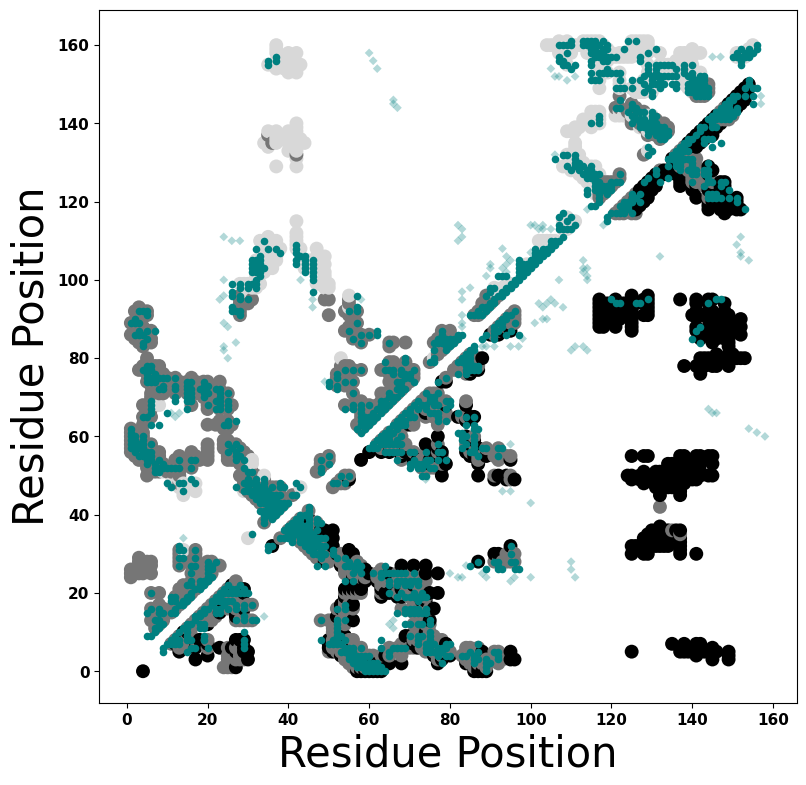

In [19]:
#@title Plot coevolutionary predictions on dual fold contact map

class PLOT():
    def FS_plot(self,pdb1,pdb2,df_dist,df,msa,df_sorted,name='n',plddt=['none']):
        counts = df_sorted['sort'].value_counts()
        colors = {'pdb_1':'#d8d8d8', 'pdb_2':'#000000','both':'#767676'}

        df_plot = df_sorted.copy()
        f, ax = plt.subplots(1,1,figsize=(9,9))

        if df_dist.empty == False:
            ax.scatter(x=df_dist['i'], y=df_dist['j'], s=30, c=df_dist['pdb'].map(colors),linewidth=0)
        ax.scatter(x=df['i'], y=df['j'],c=df['pdb'].map(colors), s=100, linewidth=0, label=df['pdb'])
        
        df_plot = df_plot.drop(df_plot[df_plot.group == -1].index)
        df_other = df_plot.loc[df_plot["sort"] == 'noise']
        df_temp = df_other.rename({'i':'j', 'j':'i'}, axis=1)
        df_other = pd.concat([df_other,df_temp])
        df_plot = df_plot.drop(df_plot[df_plot.sort == 'noise'].index)
        df_c = df_plot.loc[df_plot["sort"] == 'common']
        df_c = df_c.rename({'i':'j', 'j':'i'}, axis=1)
        df_s = df_plot.loc[df_plot["sort"] == 'pdb_1']
        df_s = df_s.rename({'i':'j', 'j':'i'}, axis=1)
        df_plot = df_plot.drop(df_plot[df_plot.sort == 'pdb_1'].index)
        df_plot = pd.concat([df_plot,df_s])
        df_plot = pd.concat([df_plot,df_c])

        plot = ax.scatter(x=df_plot['j'], y=df_plot['i'], s=30, linewidth=0, c='#008080')
        
        df_other = df_other.drop_duplicates()
        ax.scatter(x=df_other['i'], y=df_other['j'],c='#008080', s=20,edgecolor='None',marker='D', alpha=0.3)

        #_______________________________________________________________________________________________________________________________
        #Final adjustments to image
        ax.set_xlabel('Residue Position', fontsize=30)
        ax.set_ylabel('Residue Position', fontsize=30)
        plt.xticks(fontsize=11, weight = 'bold')
        plt.yticks(fontsize=11, weight = 'bold')

        #_______________________________________________________________________________________________________________________________
        if name == 'n':
            name = msa.split('/')
            plt.savefig('{:}.png'.format(name[-1][:-4]),dpi=200)
        else:
            plt.savefig('{:}.png'.format(name),dpi=200)

plot = PLOT()
plot.FS_plot('pdb_1', 'pdb_2', df_pdb_1_2.loc[df_pdb_1_2['type'] == 'INTER'], df_pdb_1_2.loc[df_pdb_1_2['type'] == 'INTRA'], MSA_file, df_sorted)

print('-------Results for full Pipeline-------')
print('Total predictions: {:}'.format(len(df_sorted[df_sorted['group'] != -1].index)))
print('Percent within +-1 of first fold:  {:}'.format(len(df_sorted[(df_sorted['group'] != -1) & (df_sorted['sort'] == 'pdb_1')])))
print('Percent within +-1 of second fold: {:}'.format(len(df_sorted[(df_sorted['group'] != -1) & (df_sorted['sort'] == 'pdb_2')])))
print('Percent within +-1 of common fold: {:}'.format(len(df_sorted[(df_sorted['group'] != -1) & (df_sorted['sort'] == 'common')])))
print('Average radial distance of noise from xcrystal : {:}'.format(df_sorted['r'].mean()))
print('\n')